In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import time

from IPython import display

# %matplotlib notebook


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
dataset = 'horse2zebra'

data = tfds.load('cycle_gan/' + dataset)
train_x = data['trainA']
train_y = data['trainB']
test_x = data['testA']
test_y = data['testB']

print('train_x: ', train_x)
print('train_y: ', train_y)
print('test_x: ', test_x)
print('test_y: ', test_y)

train_x:  <DatasetV1Adapter shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
train_y:  <DatasetV1Adapter shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
test_x:  <DatasetV1Adapter shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
test_y:  <DatasetV1Adapter shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>


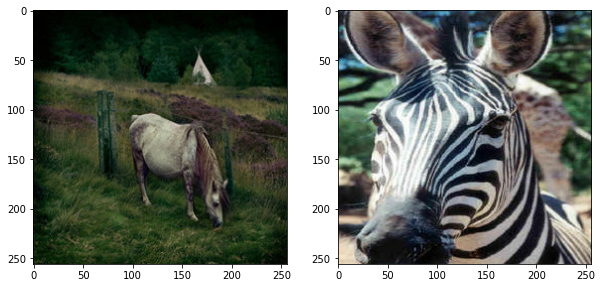

In [3]:
x = next(iter(test_x))
y = next(iter(test_y))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x['image'])

plt.subplot(1, 2, 2)
plt.imshow(y['image'])

plt.show()

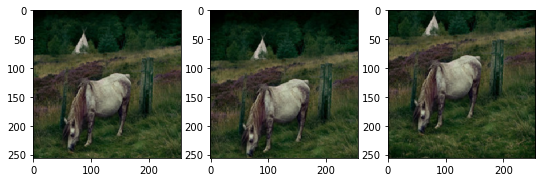

In [4]:
def normalize(image):
    return tf.cast(image, tf.float32) / 127.5 - 1.0


def resize(image, width, height):
    image = tf.image.resize(image, [height, width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image


@tf.function
def random_jitter(image):
    image = resize(image, 300, 300)
    image = tf.image.random_crop(image, [256, 256, 3])
    image = tf.image.random_flip_left_right(image)
    return normalize(image)


plt.figure(figsize=(9, 3))
for i in range(3):
    distorted_apple = random_jitter(x['image'])
    plt.subplot(1, 3, i+1)
    plt.imshow(distorted_apple * 0.5 + 0.5)
plt.show()

In [5]:
def train_pipeline(entry):
    return random_jitter(entry['image'])


def test_pipeline(entry):
    return normalize(entry['image'])


SHUFFLE_SIZE = 500
train_x_ds = train_x.shuffle(SHUFFLE_SIZE).map(train_pipeline).batch(1)
train_y_ds = train_y.shuffle(SHUFFLE_SIZE).map(train_pipeline).batch(1)

test_x_ds = test_x.shuffle(SHUFFLE_SIZE).map(test_pipeline).batch(1)
test_y_ds = test_y.shuffle(SHUFFLE_SIZE).map(test_pipeline).batch(1)

print(train_x_ds)
print(train_y_ds)
print(test_x_ds)
print(test_y_ds)

<DatasetV1Adapter shapes: (None, 256, 256, 3), types: tf.float32>
<DatasetV1Adapter shapes: (None, 256, 256, 3), types: tf.float32>
<DatasetV1Adapter shapes: (None, None, None, 3), types: tf.float32>
<DatasetV1Adapter shapes: (None, None, None, 3), types: tf.float32>


In [8]:
class InstanceNormalization(tf.keras.layers.Layer):
    """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(name='scale',
                                     shape=input_shape[-1:],
                                     initializer=tf.random_normal_initializer(1., 0.02),
                                     trainable=True)

        self.offset = self.add_weight(name='offset',
                                      shape=input_shape[-1:],
                                      initializer='zeros',
                                      trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset


class InstanceNormedConv(keras.layers.Layer):
    def __init__(self, filter_size, kernel_size, strides=1, activation=keras.layers.ReLU(), apply_norm=True):
        super(InstanceNormedConv, self).__init__()
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.strides = strides
        self.activation = activation
        self.apply_norm = apply_norm

    def build(self, input_shape):
        self.conv = keras.layers.Conv2D(self.filter_size,
                                        self.kernel_size,
                                        strides=self.strides,
                                        padding='same',
                                        use_bias=False)
        if self.apply_norm:
            self.norm = InstanceNormalization()
        self.activation = self.activation

    def call(self, x):
        x = self.conv(x)
        if self.apply_norm:
            x = self.norm(x)
        x = self.activation(x)
        return x


class ResnetBlock(keras.layers.Layer):
    def __init__(self, filter_size, kernel_size):
        super(ResnetBlock, self).__init__()
        self.filter_size = filter_size
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv1 = keras.layers.Conv2D(self.filter_size,
                                         self.kernel_size,
                                         strides=1,
                                         padding='same',
                                         use_bias=False)
        self.norm1 = InstanceNormalization()
        self.relu = keras.layers.ReLU()
        
        self.conv2 = keras.layers.Conv2D(self.filter_size,
                                         self.kernel_size,
                                         strides=1,
                                         padding='same',
                                         use_bias=False)
        self.norm2 = InstanceNormalization()

    def call(self, x):
        output = self.conv1(x)
        output = self.norm1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.norm2(output)
        return x + output


class InstanceNormedConvTranspose(keras.layers.Layer):
    def __init__(self, filter_size, kernel_size, strides=1):
        super(InstanceNormedConvTranspose, self).__init__()
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.strides = strides

    def build(self, input_shape):
        self.conv = keras.layers.Conv2DTranspose(self.filter_size,
                                                 self.kernel_size,
                                                 strides=self.strides,
                                                 padding='same',
                                                 use_bias=False)
        self.norm = InstanceNormalization()
        self.relu = keras.layers.ReLU()

    def call(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x


def build_generator_unet():
    input_images = keras.layers.Input(shape=[256, 256, 3])
    x = InstanceNormedConv(64, 7, 1)(input_images)
    x = InstanceNormedConv(128, 4, 2)(x)
    x = InstanceNormedConv(256, 4, 2)(x)
    
    for _ in range(9):
        x = ResnetBlock(256, 4)(x)
    
    x = InstanceNormedConvTranspose(128, 4, 2)(x)
    x = InstanceNormedConvTranspose(64, 4, 2)(x)
    x = keras.layers.Conv2D(3, 7, 1, padding='same', activation='tanh')(x)
    
    model = keras.models.Model(inputs=[input_images], outputs=[x])
    return model


def build_discriminator():
    input_images = keras.layers.Input(shape=[256, 256, 3])
    x = InstanceNormedConv(64, 4, 2, activation=keras.layers.LeakyReLU(0.2), apply_norm=False)(input_images)
    x = InstanceNormedConv(128, 4, 2, activation=keras.layers.LeakyReLU(0.2))(x)
    x = InstanceNormedConv(256, 4, 2, activation=keras.layers.LeakyReLU(0.2))(x)
    
    initializer = tf.random_normal_initializer(0, 0.02)
    x = keras.layers.ZeroPadding2D()(x)
    x = keras.layers.Conv2D(512, 4, 1, use_bias=False,
                            kernel_initializer=initializer)(x)
    x = InstanceNormalization()(x)
    x = keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.ZeroPadding2D()(x)
    outputs = tf.keras.layers.Conv2D(1, 4, strides=1,
                                     kernel_initializer=initializer)(x) # (bs, 30, 30, 1)
    
    model = keras.models.Model(inputs=[input_images], outputs=[outputs])
    return model


keras.backend.clear_session()
G = build_generator_unet()
F = build_generator_unet()
G.summary()
F.summary()


Dg = build_discriminator()
Df = build_discriminator()
Dg.summary()
Df.summary()

g_opt = keras.optimizers.Adam(2.5e-4, beta_1=0.5)
f_opt = keras.optimizers.Adam(2.5e-4, beta_1=0.5)
dg_opt = keras.optimizers.Adam(2.5e-4, beta_1=0.5)
df_opt = keras.optimizers.Adam(2.5e-4, beta_1=0.5)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
instance_normed_conv (Instan (None, 256, 256, 64)      9536      
_________________________________________________________________
instance_normed_conv_1 (Inst (None, 128, 128, 128)     131328    
_________________________________________________________________
instance_normed_conv_2 (Inst (None, 64, 64, 256)       524800    
_________________________________________________________________
resnet_block (ResnetBlock)   (None, 64, 64, 256)       2098176   
_________________________________________________________________
resnet_block_1 (ResnetBlock) (None, 64, 64, 256)       2098176   
_________________________________________________________________
resnet_block_2 (ResnetBlock) (None, 64, 64, 256)       209817

In [9]:
ALPHA = 10

def image_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def cls_loss(y_true, y_pred):
    return keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)

def discriminator_loss(fake, real):
    loss = cls_loss(tf.zeros_like(fake), fake) + cls_loss(tf.ones_like(real), real)
    return loss / 2.0

def generator_loss(y, y_same, fake):
    return ALPHA / 2.0 * image_loss(y, y_same) + cls_loss(tf.ones_like(fake), fake)

def cycle_loss(y, cycled_y):
    return ALPHA * image_loss(y, cycled_y)

@tf.function
def train_step(x, y):
    """
    G: x -> y
    F: y -> x
    Dg: y -> 1, y_hat -> 0
    Df: x -> 1, x_hat -> 0
    """
    
    with tf.GradientTape(persistent=True) as tape:
        y_hat = G(x, training=True)
        x_hat = F(y, training=True)
        same_y = G(y, training=True)
        same_x = F(x, training=True)
        dg_fake = Dg(y_hat, training=True)
        df_fake = Df(x_hat, training=True)
        dg_real = Dg(y, training=True)
        df_real = Df(x, training=True)
        cycle_x = F(y_hat, training=True)
        cycle_y = G(x_hat, training=True)
        
        total_cycle_loss = cycle_loss(x, cycle_x) + cycle_loss(y, cycle_y)
        total_g_loss = generator_loss(y, same_y, dg_fake) + total_cycle_loss
        total_f_loss = generator_loss(x, same_x, df_fake) + total_cycle_loss
        dg_loss = discriminator_loss(dg_fake, dg_real)
        df_loss = discriminator_loss(df_fake, df_real)
        
    g_grad = tape.gradient(total_g_loss, G.trainable_variables)
    f_grad = tape.gradient(total_f_loss, F.trainable_variables)
    dg_grad = tape.gradient(dg_loss, Dg.trainable_variables)
    df_grad = tape.gradient(df_loss, Df.trainable_variables)
    
    g_opt.apply_gradients(zip(g_grad, G.trainable_variables))
    f_opt.apply_gradients(zip(f_grad, F.trainable_variables))
    dg_opt.apply_gradients(zip(dg_grad, Dg.trainable_variables))
    df_opt.apply_gradients(zip(df_grad, Df.trainable_variables))
    
    return total_cycle_loss, total_g_loss, total_f_loss, dg_loss, df_loss


train_ds = tf.data.Dataset.zip((train_x_ds, train_y_ds))
train_iter = iter(train_ds)
x, y = next(train_iter)
train_step(x, y)

(<tf.Tensor: shape=(), dtype=float32, numpy=14.364252>,
 <tf.Tensor: shape=(), dtype=float32, numpy=18.37135>,
 <tf.Tensor: shape=(), dtype=float32, numpy=18.517086>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9140859>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8388244>)

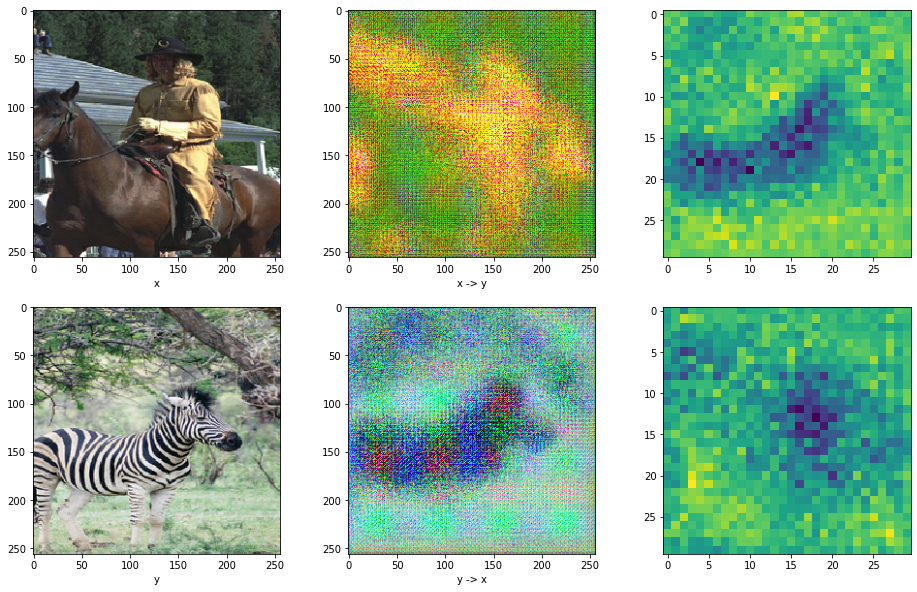

In [10]:
def generate_images(x, y):
    fake_y = G(x, training=False)
    fake_x = F(y, training=False)
    dg_map = Dg(fake_x, training=False)
    df_map = Df(fake_y, training=False)
    
    plt.subplot(2, 3, 1)
    plt.imshow(x[0] * 0.5 + 0.5)
    plt.xlabel('x')
    
    plt.subplot(2, 3, 2)
    plt.imshow(fake_y[0] * 0.5 + 0.5)
    plt.xlabel('x -> y')
    
    plt.subplot(2, 3, 3)
    plt.imshow(dg_map[0, :, :, 0])
    
    plt.subplot(2, 3, 4)
    plt.imshow(y[0] * 0.5 + 0.5)
    plt.xlabel('y')
    
    plt.subplot(2, 3, 5)
    plt.imshow(fake_x[0] * 0.5 + 0.5)
    plt.xlabel('y -> x')
    
    plt.subplot(2, 3, 6)
    plt.imshow(df_map[0, :, :, 0])


plt.figure(figsize=(16, 10))
x, y = next(train_iter)
generate_images(x, y)
plt.show()

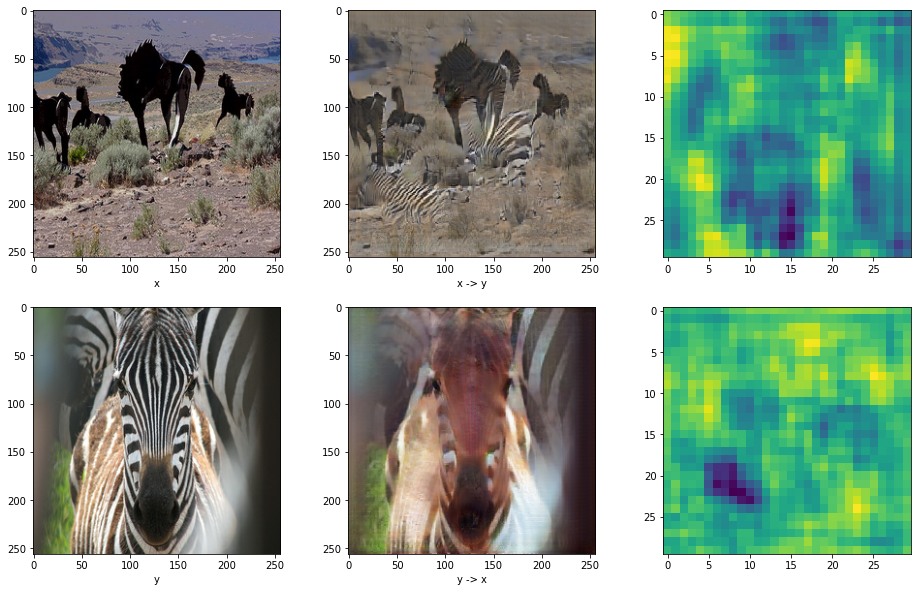

time used last epoch:  647.0624094009399
epoch:  59
1066. cycle_loss: 2.528847, g_loss: 4.533403, f_loss: 4.094632, dg_loss: 0.480343, df_loss: 0.578107

In [11]:
def train(train_ds, test_ds, epochs=60):
    test_iter = iter(test_ds)
    time_used = 0
    for epoch in range(epochs):
        display.clear_output(wait=True)
        
        test_x, test_y = next(test_iter)
        plt.figure(figsize=(16, 10))
        generate_images(test_x, test_y)
        plt.show()
        
        if time_used:
            print('time used last epoch: ', time_used)
        
        print('epoch: ', epoch)
        start = time.time()
        losses = [[] for _ in range(5)]
        step = 0
        for x, y in train_ds:
            l = train_step(x, y)
            for i in range(5):
                losses[i].append(l[i].numpy())
    
            print('\r%d. cycle_loss: %f, g_loss: %f, f_loss: %f, dg_loss: %f, df_loss: %f' %
                  (step, np.mean(losses[0]), np.mean(losses[1]), np.mean(losses[2]),
                   np.mean(losses[3]), np.mean(losses[4])), end='')
            step += 1
        time_used = time.time() - start
        


test_ds = tf.data.Dataset.zip((test_x_ds, test_y_ds))
train(train_ds, test_ds)

In [12]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../checkpoint/%s/%s.checkpoint' % (dataset, dataset))

'../checkpoint/horse2zebra/horse2zebra.checkpoint-1'

In [13]:
test_iter = iter(test_ds)

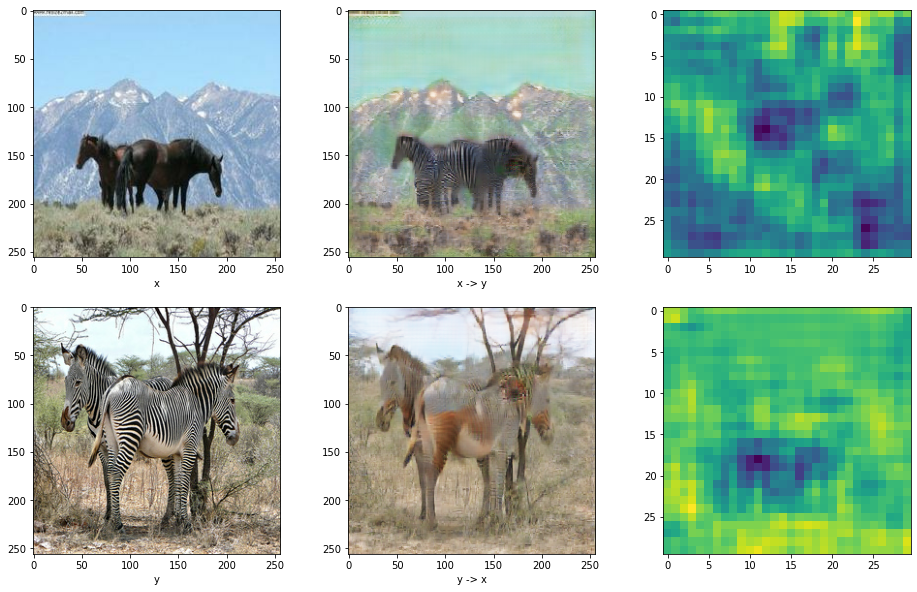

In [14]:
plt.figure(figsize=(16, 10))
horses, zebras = next(test_iter)
generate_images(horses, zebras)
plt.show()